In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


In [43]:
# Load data we downlaoded in the previous notebook
ticker = "AAPL"
data = pd.read_csv(f'../data/{ticker}_historical.csv', index_col='Date', parse_dates=True)

print(f"Loaded {len(data)} rows of data")
print(f"Date range: {data.index[0]} to {data.index[-1]}")
print(f"\nColumns: {list(data.columns)}")
print(f"\nFirst few rows:")
data.head()

Loaded 1258 rows of data
Date range: 2020-01-02 00:00:00 to 2024-12-31 00:00:00

Columns: ['Close', 'High', 'Low', 'Open', 'Volume']

First few rows:


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.400505,72.460769,71.156667,71.409770,135480400
2020-01-03,71.696640,72.455958,71.472462,71.629145,146322800
2020-01-06,72.267921,72.306491,70.568495,70.819193,118387200
2020-01-07,71.928047,72.533087,71.708687,72.277571,108872000
2020-01-08,73.085098,73.386416,71.631544,71.631544,132079200


Check for missing rows

In [44]:
# Check data quality
print("Missing values per column:")
print(data.isnull().sum())
print(f"\nTotal missing values: {data.isnull().sum().sum()}")

# Check data types
print(f"\nData types:")
print(data.dtypes)

Missing values per column:
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Total missing values: 0

Data types:
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object


In [45]:
data = data.fillna(method='ffill')

In [46]:
# Create a copy to work with
df = data.copy()

# Lagged prices (yesterday's price, 2 days ago, etc...)
df['price_lag1'] = df['Close'].shift(1)
df['price_lag2'] = df['Close'].shift(2)
df['price_lag3'] = df['Close'].shift(3)
df['price_lag5'] = df['Close'].shift(5)

# Price changes
df['price_change'] = df['Close'] - df['Close'].shift(1)
df['price_change_pct'] = df['Close'].pct_change()

# High-Low Spread
df['high_low_spread'] = df['High'] - df['Low']
df['high_low_pct'] = (df['High'] - df['Low']) / df['Close']

# Open-Close difference
df['open_close_diff'] = df['Close'] - df['Open']
df['open_close_pct'] = (df['Close'] - df['Open']) / df['Open']

print(f"Created basic price features. New column count: {len(df.columns)}")
df[['Close', 'price_lag1', 'price_change', 'high_low_spread']].head(10)

Created basic price features. New column count: 15


,Close,price_lag1,price_change,high_low_spread
Date,,,,
2020-01-02,72.400505,NaN,NaN,1.304102
2020-01-03,71.696640,72.400505,-0.703865,0.983496
2020-01-06,72.267921,71.696640,0.571281,1.737996
2020-01-07,71.928047,72.267921,-0.339874,0.824400
2020-01-08,73.085098,71.928047,1.157051,1.754871
2020-01-09,74.637482,73.085098,1.552383,1.019653
2020-01-10,74.806229,74.637482,0.168747,1.065461
2020-01-13,76.404419,74.806229,1.598190,1.427042
2020-01-14,75.372704,76.404419,-1.031715,1.301689


## Moving Averages

In [47]:
# Simple Moving Averages (SMA)
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Exponential Moving Averages (EMA) - give more weight to recent prices
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()

# Moving average crossovers (important trading signals)
df['MA5_MA20_diff'] = df['MA5'] - df['MA20']
df['price_to_MA20'] = df['Close'] / df['MA20']
df['price_to_MA50'] = df['Close'] / df['MA50']

print(f"Created moving average features. New column count: {len(df.columns)}")

Created moving average features. New column count: 25


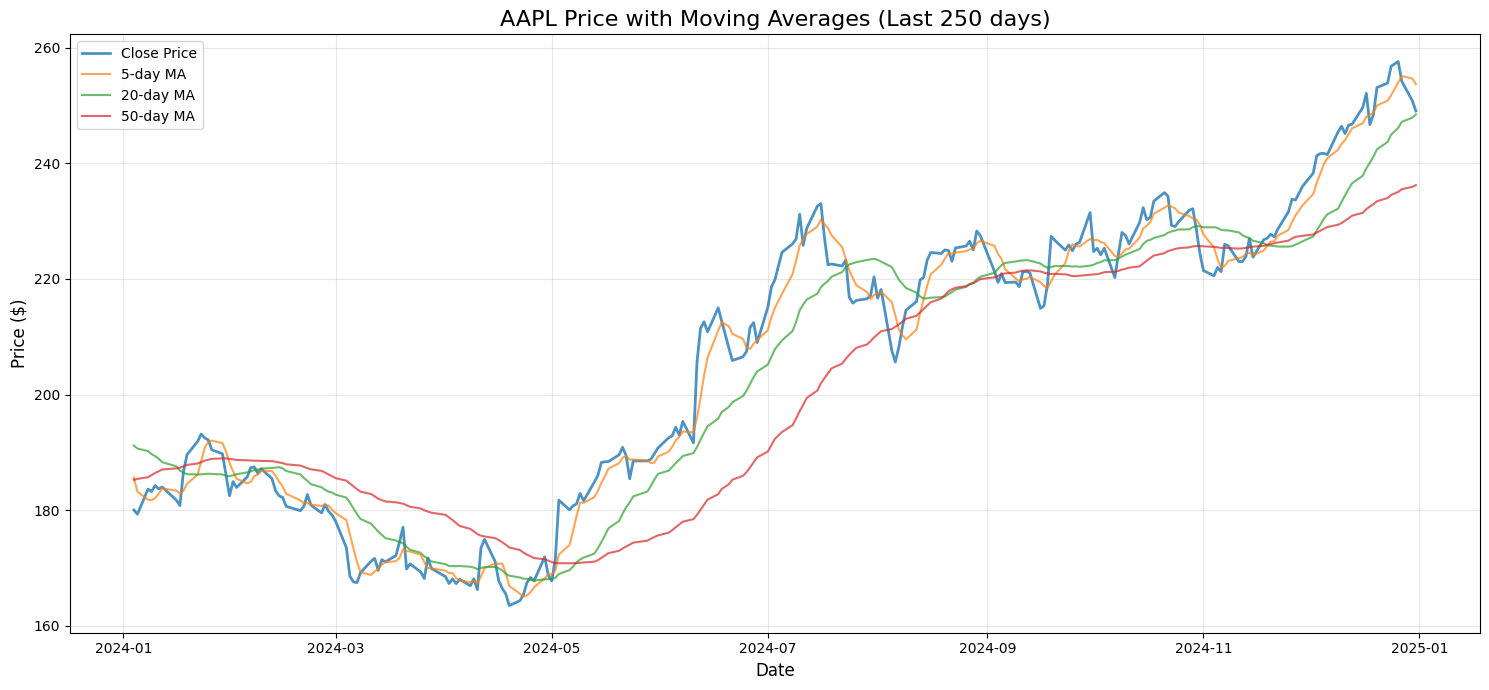

In [48]:
# Plot price with MAs
plt.figure(figsize=(15, 7))

# Plot last 250 days for clarity
plot_data = df.tail(250)

plt.plot(plot_data.index, plot_data['Close'], label='Close Price', linewidth=2, alpha=0.8)
plt.plot(plot_data.index, plot_data['MA5'], label='5-day MA', linewidth=1.5, alpha=0.7)
plt.plot(plot_data.index, plot_data['MA20'], label='20-day MA', linewidth=1.5, alpha=0.7)
plt.plot(plot_data.index, plot_data['MA50'], label='50-day MA', linewidth=1.5, alpha=0.7)

plt.title(f'{ticker} Price with Moving Averages (Last 250 days)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Technical Indicators

## RSI

RSI Statistics:
count    1245.000000
mean       54.597190
std        12.126837
min        22.223708
25%        44.694286
50%        55.004055
75%        64.154970
max        82.042865
Name: RSI, dtype: float64


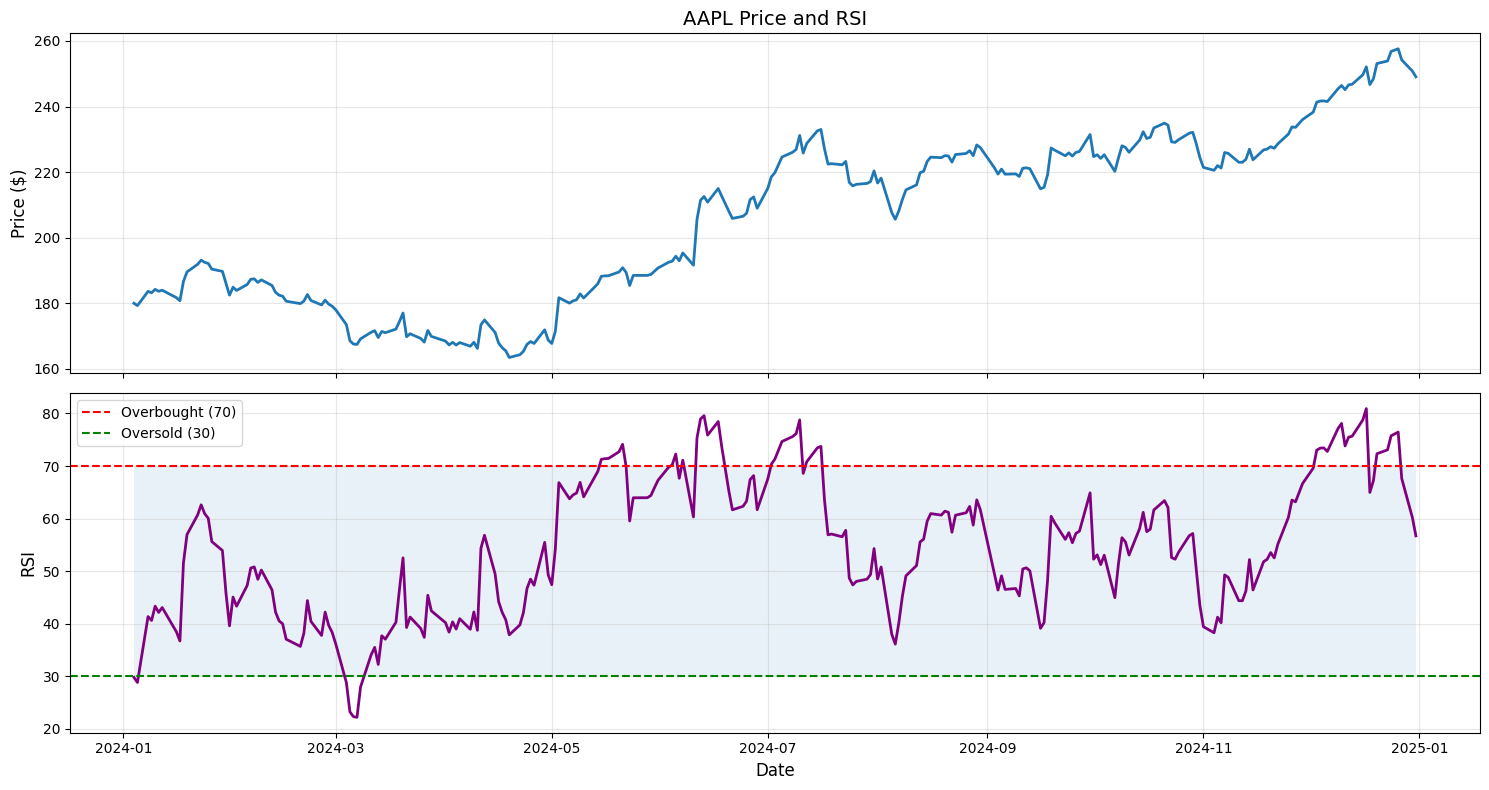

In [49]:
from ta.momentum import RSIIndicator

rsi_indicator = RSIIndicator(close=df['Close'], window=14)
df['RSI'] = rsi_indicator.rsi()

print("RSI Statistics:")
print(df['RSI'].describe())

# Visualize RSI (same visualization as before)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True)

plot_data = df.tail(250)

# Price
ax1.plot(plot_data.index, plot_data['Close'], linewidth=2)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title(f'{ticker} Price and RSI', fontsize=14)
ax1.grid(True, alpha=0.3)

# RSI
ax2.plot(plot_data.index, plot_data['RSI'], color='purple', linewidth=2)
ax2.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
ax2.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
ax2.fill_between(plot_data.index, 30, 70, alpha=0.1)
ax2.set_ylabel('RSI', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## MACD

MACD created successfully


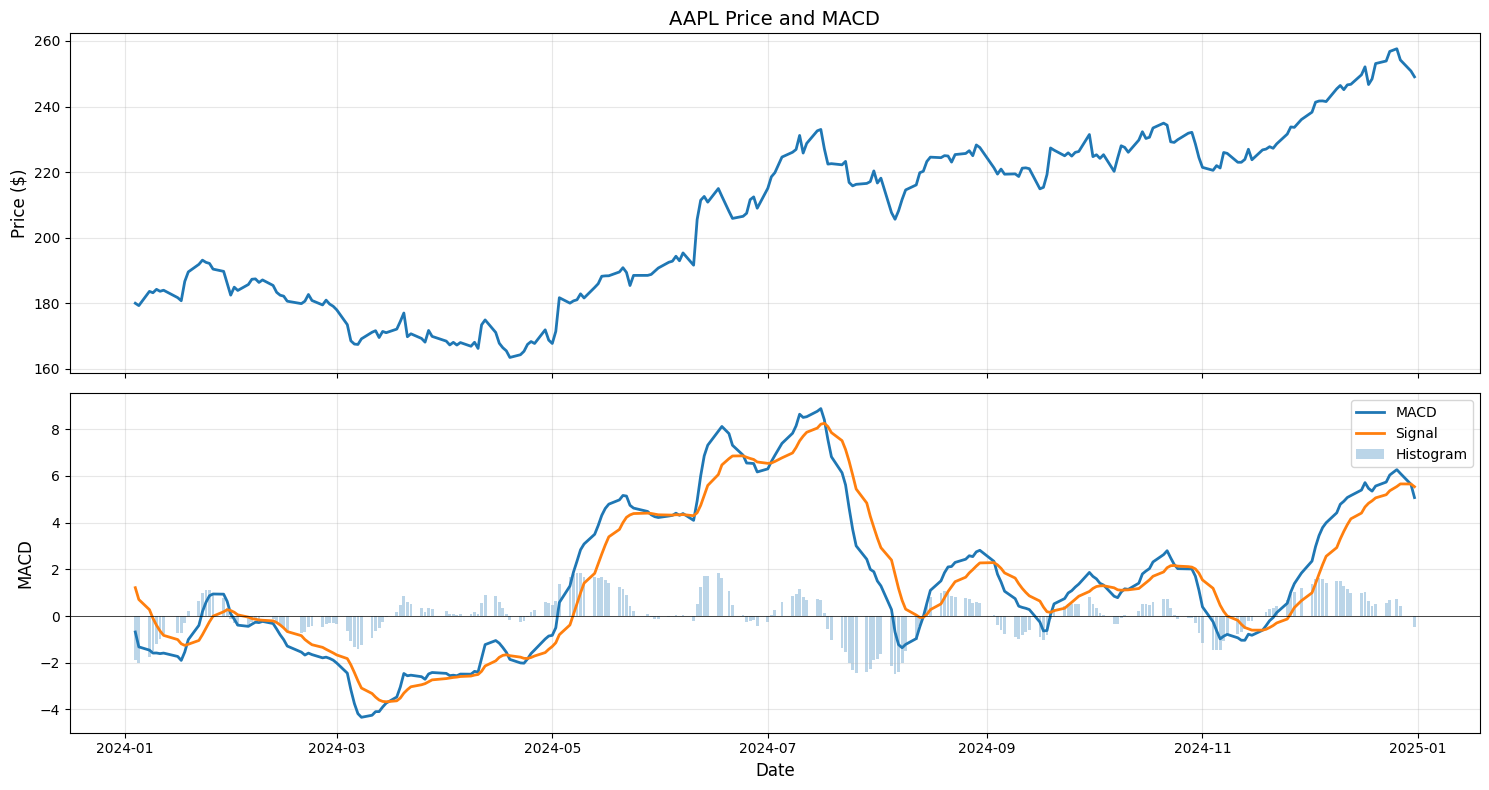

In [50]:
from ta.trend import MACD
macd_indicator = MACD(close=df['Close'])
df['MACD'] = macd_indicator.macd()
df['MACD_signal'] = macd_indicator.macd_signal()
df['MACD_hist'] = macd_indicator.macd_diff()

print("MACD created successfully")

# Visualize MACD 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

plot_data = df.tail(250)

# Price
ax1.plot(plot_data.index, plot_data['Close'], linewidth=2)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title(f'{ticker} Price and MACD', fontsize=14)
ax1.grid(True, alpha=0.3)

# MACD
ax2.plot(plot_data.index, plot_data['MACD'], label='MACD', linewidth=2)
ax2.plot(plot_data.index, plot_data['MACD_signal'], label='Signal', linewidth=2)
ax2.bar(plot_data.index, plot_data['MACD_hist'], label='Histogram', alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('MACD', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Bollinger Bands

Bollinger Bands created!


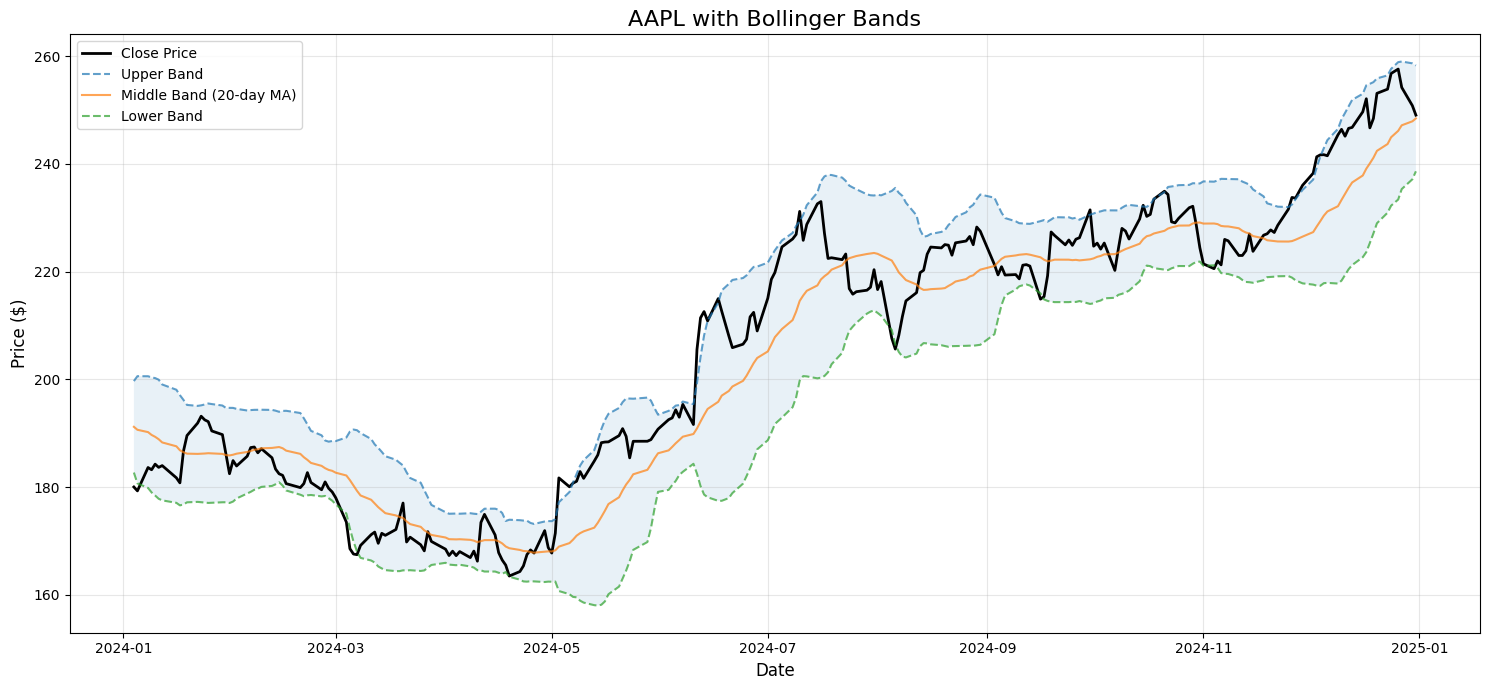

In [51]:
from ta.volatility import BollingerBands

bb_indicator = BollingerBands(close=df['Close'], window=20, window_dev=2)
df['BB_upper'] = bb_indicator.bollinger_hband()
df['BB_middle'] = bb_indicator.bollinger_mavg()
df['BB_lower'] = bb_indicator.bollinger_lband()
df['BB_width'] = df['BB_upper'] - df['BB_lower']
df['BB_position'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

print("Bollinger Bands created!")

plt.figure(figsize=(15, 7))

plot_data = df.tail(250)

plt.plot(plot_data.index, plot_data['Close'], label='Close Price', linewidth=2, color='black')
plt.plot(plot_data.index, plot_data['BB_upper'], label='Upper Band', linestyle='--', alpha=0.7)
plt.plot(plot_data.index, plot_data['BB_middle'], label='Middle Band (20-day MA)', alpha=0.7)
plt.plot(plot_data.index, plot_data['BB_lower'], label='Lower Band', linestyle='--', alpha=0.7)
plt.fill_between(plot_data.index, plot_data['BB_lower'], plot_data['BB_upper'], alpha=0.1)

plt.title(f'{ticker} with Bollinger Bands', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Volume indicators created!


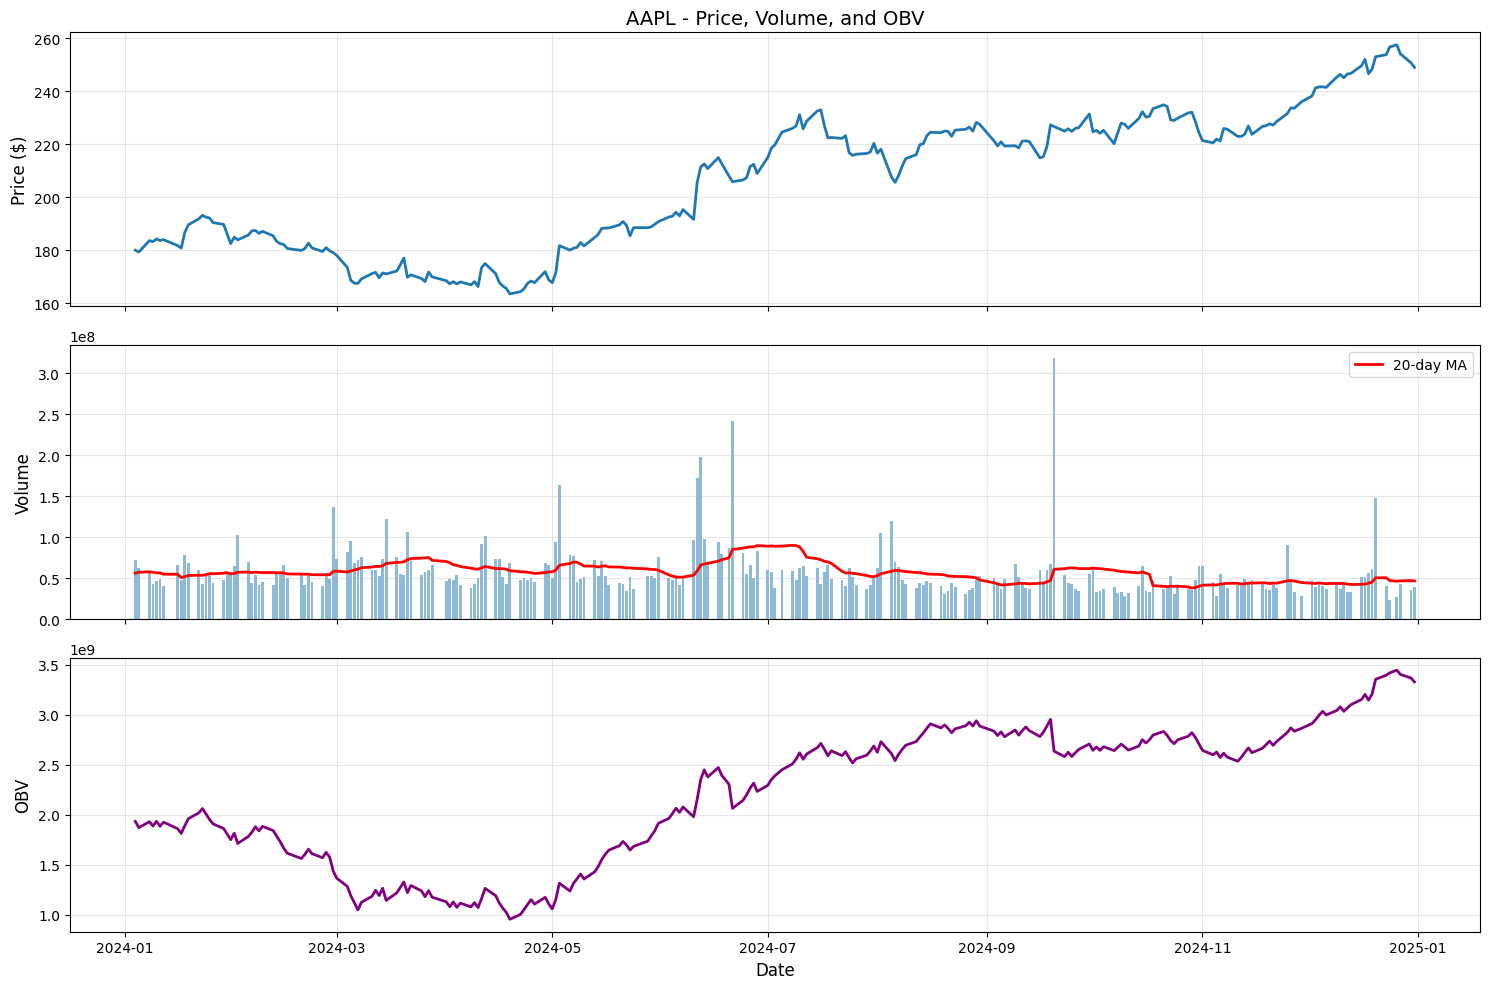

In [52]:
df['volume_ma5'] = df['Volume'].rolling(window=5).mean()
df['volume_ma20'] = df['Volume'].rolling(window=20).mean()
df['volume_ratio'] = df['Volume'] / df['volume_ma20']
df['volume_change'] = df['Volume'].pct_change()

from ta.volume import OnBalanceVolumeIndicator

obv_indicator = OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume'])
df['OBV'] = obv_indicator.on_balance_volume()

print("Volume indicators created!")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

plot_data = df.tail(250)

# Price
ax1.plot(plot_data.index, plot_data['Close'], linewidth=2)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title(f'{ticker} - Price, Volume, and OBV', fontsize=14)
ax1.grid(True, alpha=0.3)

# Volume
ax2.bar(plot_data.index, plot_data['Volume'], alpha=0.5)
ax2.plot(plot_data.index, plot_data['volume_ma20'], color='red', label='20-day MA', linewidth=2)
ax2.set_ylabel('Volume', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# OBV
ax3.plot(plot_data.index, plot_data['OBV'], color='purple', linewidth=2)
ax3.set_ylabel('OBV', fontsize=12)
ax3.set_xlabel('Date', fontsize=12)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [53]:
# Stochastic Oscillator
from ta.momentum import StochasticOscillator

stoch_indicator = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'])
df['STOCH_k'] = stoch_indicator.stoch()
df['STOCH_d'] = stoch_indicator.stoch_signal()

# Average True Range
from ta.volatility import AverageTrueRange

atr_indicator = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14)
df['ATR'] = atr_indicator.average_true_range()

# Commodity Channel Index
from ta.trend import CCIIndicator

cci_indicator = CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20)
df['CCI'] = cci_indicator.cci()

# Williams %R
from ta.momentum import WilliamsRIndicator

willr_indicator = WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=14)
df['WILLR'] = willr_indicator.williams_r()

print(f"All technical indicators created!")
print(f"Total features now: {len(df.columns)}")

All technical indicators created!
Total features now: 44


In [54]:
# What we're trying to predict: next day's closing price
df['target'] = df['Close'].shift(-1)

# Also create classification target: will price go up or down?
df['target_direction'] = np.where(df['target'] > df['Close'], 1, 0)  # 1 = up, 0 = down

print("Target variables created!")
print(f"\nDirection distribution:")
print(df['target_direction'].value_counts())
print(f"\nPercentage going up: {df['target_direction'].mean()*100:.2f}%")

Target variables created!

Direction distribution:
target_direction
1    670
0    588
Name: count, dtype: int64

Percentage going up: 53.26%


To handle missing values from indicators

In [55]:
# Check how many NaN values we have
print("Missing values per column:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

print(f"\nTotal rows: {len(df)}")
print(f"Rows with any NaN: {df.isnull().any(axis=1).sum()}")

# Drop rows with NaN (mostly at the beginning due to rolling windows)
df_clean = df.dropna()

print(f"\nRows after dropping NaN: {len(df_clean)}")
print(f"Rows dropped: {len(df) - len(df_clean)}")

Missing values per column:
MA200               199
MA50                 49
price_to_MA50        49
MACD_signal          33
MACD_hist            33
MACD                 25
MA20                 19
price_to_MA20        19
volume_ma20          19
BB_position          19
BB_width             19
BB_lower             19
BB_middle            19
BB_upper             19
MA5_MA20_diff        19
CCI                  19
volume_ratio         19
STOCH_d              15
RSI                  13
WILLR                13
STOCH_k              13
MA10                  9
price_lag5            5
MA5                   4
volume_ma5            4
price_lag3            3
price_lag2            2
price_change          1
price_change_pct      1
price_lag1            1
volume_change         1
target                1
dtype: int64

Total rows: 1258
Rows with any NaN: 200

Rows after dropping NaN: 1058
Rows dropped: 200


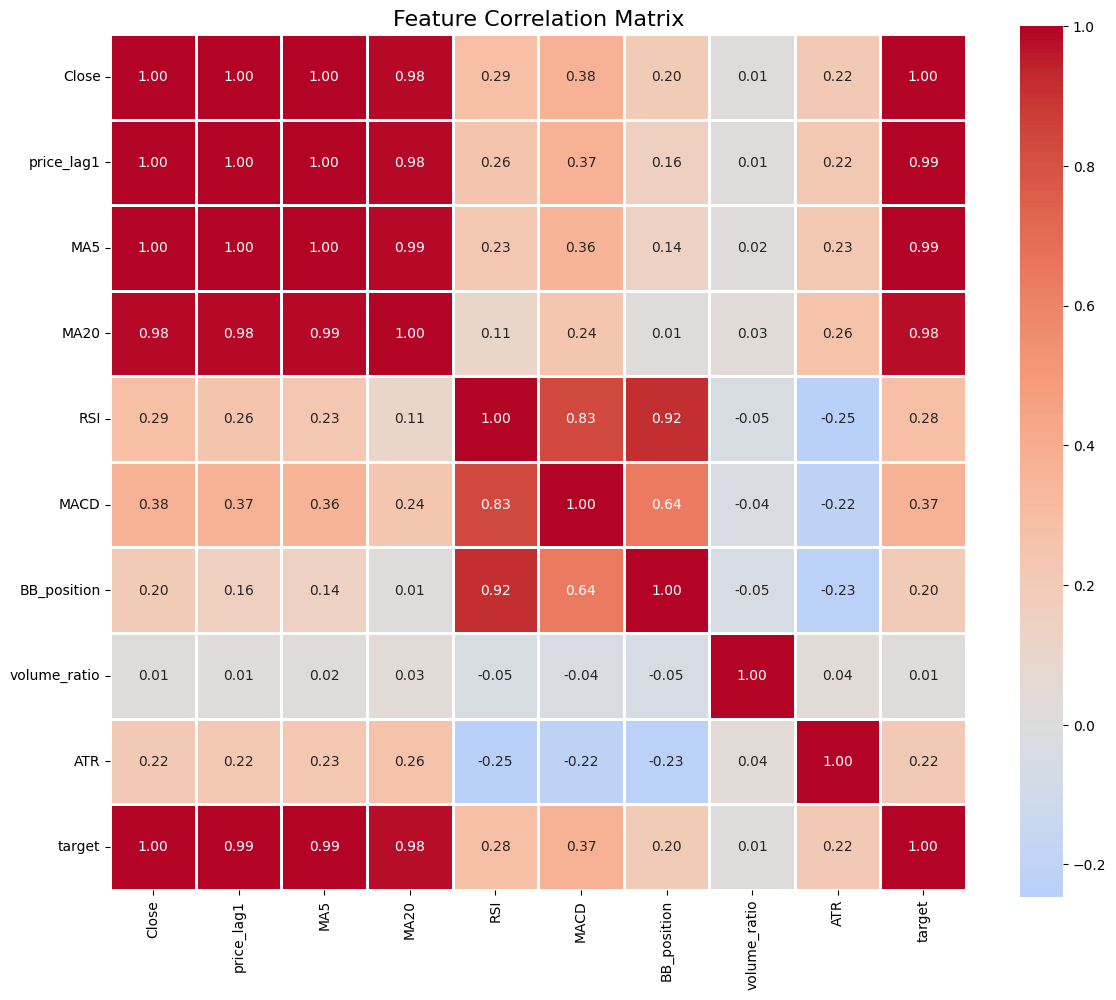


Correlation with target (next day's price):
target          1.000000
Close           0.996606
price_lag1      0.993097
MA5             0.992785
MA20            0.977539
MACD            0.372512
RSI             0.284681
ATR             0.217060
BB_position     0.196717
volume_ratio    0.014395
Name: target, dtype: float64


In [56]:
# Look at which features correlate with target
import seaborn as sns

# Select key features for correlation
key_features = ['Close', 'price_lag1', 'MA5', 'MA20', 'RSI', 'MACD', 
                'BB_position', 'volume_ratio', 'ATR', 'target']

correlation_matrix = df_clean[key_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# Show correlation with target specifically
print("\nCorrelation with target (next day's price):")
target_corr = correlation_matrix['target'].sort_values(ascending=False)
print(target_corr)

In [57]:
# Document what each feature represents
feature_categories = {
    'Price-based': ['Close', 'Open', 'High', 'Low', 'price_lag1', 'price_lag2', 
                    'price_lag3', 'price_lag5', 'price_change', 'price_change_pct'],
    'Moving Averages': ['MA5', 'MA10', 'MA20', 'MA50', 'MA200', 'EMA12', 'EMA26'],
    'Momentum': ['RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'STOCH_k', 'STOCH_d', 
                 'CCI', 'WILLR'],
    'Volatility': ['ATR', 'BB_upper', 'BB_middle', 'BB_lower', 'BB_width', 
                   'BB_position', 'high_low_spread'],
    'Volume': ['Volume', 'volume_ma5', 'volume_ma20', 'volume_ratio', 'OBV'],
    'Derived': ['MA5_MA20_diff', 'price_to_MA20', 'price_to_MA50', 'open_close_diff'],
    'Target': ['target', 'target_direction']
}

print("FEATURE CATEGORIES")
print("="*60)
for category, features in feature_categories.items():
    print(f"\n{category} ({len(features)} features):")
    for feature in features:
        if feature in df_clean.columns:
            print(f"  ✓ {feature}")
        else:
            print(f"  ✗ {feature} (not found)")

FEATURE CATEGORIES

Price-based (10 features):
  ✓ Close
  ✓ Open
  ✓ High
  ✓ Low
  ✓ price_lag1
  ✓ price_lag2
  ✓ price_lag3
  ✓ price_lag5
  ✓ price_change
  ✓ price_change_pct

Moving Averages (7 features):
  ✓ MA5
  ✓ MA10
  ✓ MA20
  ✓ MA50
  ✓ MA200
  ✓ EMA12
  ✓ EMA26

Momentum (8 features):
  ✓ RSI
  ✓ MACD
  ✓ MACD_signal
  ✓ MACD_hist
  ✓ STOCH_k
  ✓ STOCH_d
  ✓ CCI
  ✓ WILLR

Volatility (7 features):
  ✓ ATR
  ✓ BB_upper
  ✓ BB_middle
  ✓ BB_lower
  ✓ BB_width
  ✓ BB_position
  ✓ high_low_spread

Volume (5 features):
  ✓ Volume
  ✓ volume_ma5
  ✓ volume_ma20
  ✓ volume_ratio
  ✓ OBV

Derived (4 features):
  ✓ MA5_MA20_diff
  ✓ price_to_MA20
  ✓ price_to_MA50
  ✓ open_close_diff

Target (2 features):
  ✓ target
  ✓ target_direction
